## Salary Prediction

The prediction task is to determine whether a person makes over 50K a year.

The dataset and its metadata can be found [here](https://archive.ics.uci.edu/ml/datasets/Census+Income)


In [133]:
#Importing the libraries

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder


In [81]:
#importing the data
df = pd.read_csv('adult.data', header=None)

### Data Wrangling

In [82]:
#displaying the data
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Since the dataset has no meaningful names, we will rename the columnsm

In [83]:
#Storing the column names in a list

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship','race', 'sex',
 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'target']

The names were extracted from the dataset metadata

In [84]:
# renaming the column names by iteration
for index in df.columns:
     df.rename(columns = {index : column_names[index]}, inplace = True)

In [85]:
#confirming the changes
df.head()
    
    

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [86]:
#dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


There are total 15 columns and 32561 rows, The columns datatypes are correct

In [87]:
#Checking for null values
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
target            0
dtype: int64

There are no null values in the dataset

In [88]:
#converting the target column into boolean values
df['target'] = (df['target'] == ' >50K').astype('int')
df['target']


0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: target, Length: 32561, dtype: int32

1 means salary above 50k (positive class), 0 means salary less than or equal to 50K(negative class)

Investigating the target column

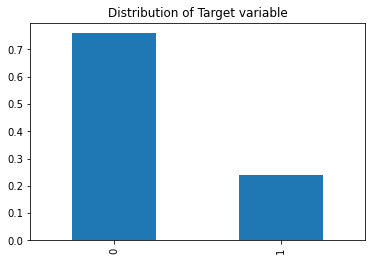

In [89]:
# checking the distinct values
df.target.value_counts(normalize = True).plot.bar()
plt.title('Distribution of Target variable');

The above shows that the negative class is our majority class.

Let's Investigate Further

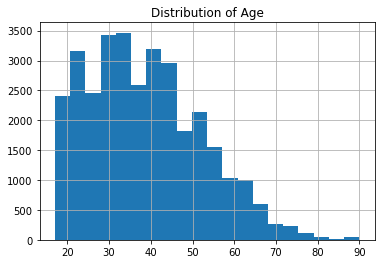

In [90]:
#Investigating the age distribution

df.age.hist(bins = 20)
plt.title('Distribution of Age');

The age is skewed to the right where most people fall in the range of 20-50.

In [91]:
#investigating the occupation
df.occupation.value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

The "?" in the values could be an error, so we will replace this with "others" and we do this for other object datatype columns

In [92]:
#iterating through the object datatype columns
for column in df.select_dtypes('object'):
    df[column] = df[column].replace(' ?', ' Others')

In [93]:
#confirming the changes
df.occupation.value_counts()


 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Others               1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [94]:
#creating a funtion to visualize the bars for each feature
def bars(feature):
    df[feature].value_counts().sort_values().plot.barh()
    plt.title(f'{feature} Counts');

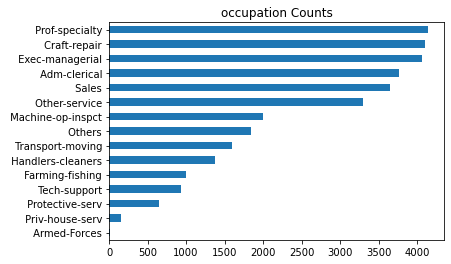

In [95]:
#visualizing the occupation
bars('occupation')

Prof-Speciality tops the occupation counts followed by Craft-repair

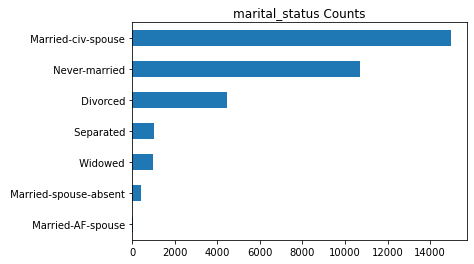

In [96]:
#visualizing the marital status
bars('marital_status')

Civilian spouse leads the marital status counts

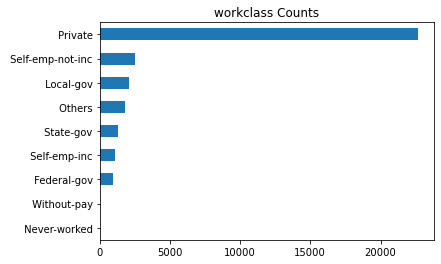

In [97]:
#visualizing the workclass
bars('workclass')

Most people work privately according to the chart above



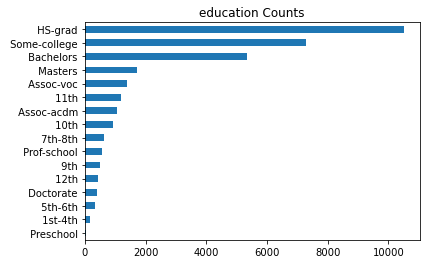

In [98]:
#visualizing the education
bars('education')

There are more HS-grad compared to others

In [99]:
# fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (30,30))
# ax = ax.ravel()
# for index, column in enumerate(df.select_dtypes('object').columns):
#     df[column].value_counts().sort_values().plot(kind = 'barh', ax = ax[index], title = f"{column} counts")
    

### SPlitting the Data

In [100]:
#splitting the data into X and y
X = df.drop(columns = 'target')
y = df['target']

In [101]:
#confirming the action
print(X.shape)
print(y.shape)

(32561, 14)
(32561,)


In [102]:
# SPlitting into the train and test data by using 20% as test size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(26048, 14)
(6513, 14)


### Buidling the Model - RandomForestClassifier

In [103]:
#setting the model baseline
baseline_score = df['target'].value_counts(normalize = True).max()
round(baseline_score, 3)

0.759

In [104]:
#creating a pipeline
clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
)

#### Tunning the hyperparameters using Gridsearch

In [105]:
params = {
    "randomforestclassifier__n_estimators" : range(10,100,10),
    "randomforestclassifier__max_depth" : range(1,40,5)
}
print(params)

{'randomforestclassifier__n_estimators': range(10, 100, 10), 'randomforestclassifier__max_depth': range(1, 40, 5)}


In [106]:
#setting the model
model = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv = 5,
    n_jobs=-1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(1, 40, 5),
                         'randomforestclassifier__n_estimators': range(10, 100, 10)},
             verbose=1)

In [107]:
#training the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(1, 40, 5),
                         'randomforestclassifier__n_estimators': range(10, 100, 10)},
             verbose=1)

In [108]:
#storing the results in a dataframe
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.456818,0.018567,0.069181,0.003437,1,10,"{'randomforestclassifier__max_depth': 1, 'rand...",0.770058,0.759309,0.759309,0.785179,0.769246,0.768620,0.009488,68
1,0.582906,0.040130,0.083975,0.019262,1,20,"{'randomforestclassifier__max_depth': 1, 'rand...",0.759309,0.759309,0.759309,0.769246,0.784412,0.766317,0.009832,70
2,0.614867,0.017747,0.083377,0.007372,1,30,"{'randomforestclassifier__max_depth': 1, 'rand...",0.759309,0.759309,0.759309,0.786715,0.762718,0.765472,0.010703,71
3,0.724063,0.027429,0.099334,0.018824,1,40,"{'randomforestclassifier__max_depth': 1, 'rand...",0.759309,0.778695,0.786180,0.759263,0.770973,0.770884,0.010621,66
4,0.846157,0.035302,0.095720,0.004114,1,50,"{'randomforestclassifier__max_depth': 1, 'rand...",0.766603,0.772169,0.759309,0.778652,0.759263,0.767199,0.007503,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4.275762,0.046598,0.273868,0.014475,36,50,"{'randomforestclassifier__max_depth': 36, 'ran...",0.845298,0.855470,0.847985,0.856594,0.865809,0.854231,0.007211,47
68,5.021367,0.037441,0.312365,0.013402,36,60,"{'randomforestclassifier__max_depth': 36, 'ran...",0.848944,0.854894,0.847601,0.859282,0.861394,0.854423,0.005459,46
69,5.748422,0.041923,0.346274,0.015025,36,70,"{'randomforestclassifier__max_depth': 36, 'ran...",0.847217,0.858541,0.856814,0.860242,0.863889,0.857341,0.005577,32
70,6.447354,0.125492,0.369012,0.016461,36,80,"{'randomforestclassifier__max_depth': 36, 'ran...",0.849712,0.855470,0.851631,0.854483,0.865617,0.855383,0.005510,39


In [109]:
#showing the best params
model.best_params_

{'randomforestclassifier__max_depth': 16,
 'randomforestclassifier__n_estimators': 80}

In [110]:
#showing the best model
model.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital_status', 'occupation',
                                      'relationship', 'race', 'sex',
                                      'native_country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping':  Local-gov           1
 Private             2
 Self-emp-not-inc    3
 Others              4
 Federal-gov         5
 Self-emp-inc        6
 State-gov           7
 Without-pay         8
 Never-worked        9
NaN                 -2
dtype: int64},
                                         {'col': 'educat...
 France                        20
 Dominican-Republic            21
 Thailand                      22
 England                       23
 Canada                        24
 Ecuador                       25
 Germany      

#### Evaluating the model

In [111]:
#using the train data first
round(model.score(X_train, y_train),3)

0.919

The model performed well on the training data, Let see for data the model has not seen before which is the test data

In [112]:
#using the test data to evaluate the model
round(model.score(X_test, y_test),3)

0.865

Our model score using the test data exceed the baseline model score but this can be misleading, so we will investigate further using the confusion matrix and classification report

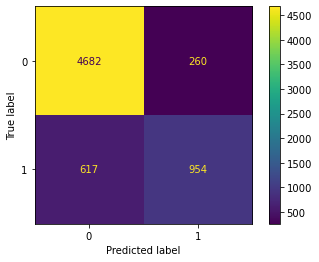

In [113]:
#Displaying the confusionMatrix
cm = confusion_matrix(y_test, model.predict(X_test))
ConfusionMatrixDisplay(cm).plot();

From the above figure, there are 607 false negative and 259 false positives

In [114]:
#Displaying the classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4942
           1       0.79      0.61      0.69      1571

    accuracy                           0.87      6513
   macro avg       0.83      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



#### Communicating the Result

In [125]:
#getting the importances of the features and storing in a series
features = model.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
feat_importance = pd.Series(features, index = X_train.columns).sort_values()
feat_importance

race              0.010876
native_country    0.014610
workclass         0.028607
education         0.029196
sex               0.030384
capital_loss      0.047287
hours_per_week    0.072475
fnlwgt            0.072629
relationship      0.073805
occupation        0.082858
age               0.113094
education_num     0.120795
marital_status    0.139395
capital_gain      0.163989
dtype: float64

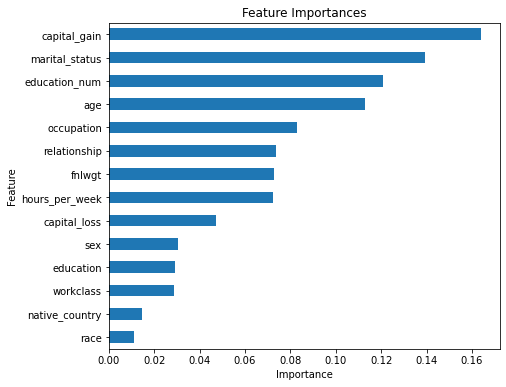

In [129]:
#Visualizing the features importances
plt.figure(figsize = (7,6))
feat_importance.plot.barh()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances');

The above bar chart shows that capital gain feature has more importance, followed by marital status. Race has the least importance in predicting whether a participant earned more than 50k or not.

#### Saving the model

In [132]:
#saving the model
with open('salary_pred.pkl', 'wb') as f:
    pickle.dump(model, f)